<h1 id="Contents">Contents<a href="#Contents"></a></h1>
        <ol>
        <li><a class="" href="#Imports">Imports</a></li>
<li><a class="" href="#Preprocessing">Preprocessing</a></li>
<ol><li><a class="" href="#Extracting-Data">Extracting Data</a></li>
<ol><li><a class="" href="#Removing-the-_backgroundnoise-folder">Removing the _backgroundnoise folder</a></li>
</ol><li><a class="" href="#Loading-the-Data">Loading the Data</a></li>
<li><a class="" href="#Creating-Train,-Test,-Val-Split">Creating Train, Test, Val Split</a></li>
<li><a class="" href="#Reading-Audio-Files">Reading Audio Files</a></li>
<ol><li><a class="" href="#Decoding-Binary-Audio-File">Decoding Binary Audio File</a></li>
<li><a class="" href="#Decoding-the-Label">Decoding the Label</a></li>
<li><a class="" href="#Plotting-The-Waveform">Plotting The Waveform</a></li>
<li><a class="" href="#Getting-Spectrogram">Getting Spectrogram</a></li>
<li><a class="" href="#Getting-Label-ID">Getting Label ID</a></li>
<li><a class="" href="#Create-the-DataSet">Create the DataSet</a></li>
</ol><li><a class="" href="#Modeling">Modeling</a></li>
<li><a class="" href="#Analysis">Analysis</a></li>
<ol><li><a class="" href="#Inference">Inference</a></li>
<ol><li><a class="" href="#Saving-the-Model">Saving the Model</a></li>
</ol><li><a class="" href="#Analyzing-the-Predictions-of-the-Model">Analyzing the Predictions of the Model</a></li>
<ol><li><a class="" href="#Plotting-Confusion-Matrix">Plotting Confusion Matrix</a></li>
</ol><li><a class="" href="#Creating-the-Submission-File">Creating the Submission File</a></li>
</ol>

# Imports

In [7]:
import os
import pathlib
import random
from IPython import display

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from scipy.io import wavfile
from tensorflow.keras import layers
from tensorflow.keras import models

# Preprocessing

## Extracting Data

In [39]:
!apt-get install -y p7zip-full
!7z x ../input/tensorflow-speech-recognition-challenge/train.7z

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-7build1).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../input/tensorflow-speech-recognition-challenge                                                          1 file, 1121103842 bytes (1070 MiB)

Extracting archive: ../input/tensorflow-speech-recognition-challenge/train.7z
--
Path = ../input/tensorflow-speech-recognition-challenge/train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

      0% 39 - train/audio/_background_noise_/dude_miaowing.w                                                          0% 41 - train/audio/_backgro

In [3]:
!7z x /kaggle/input/tensorflow-speech-recognition-challenge/sample_submission.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/tensorflow-speech-recognition-challeng                                                              1 file, 512684 bytes (501 KiB)

Extracting archive: /kaggle/input/tensorflow-speech-recognition-challenge/sample_submission.7z
--
Path = /kaggle/input/tensorflow-speech-recognition-challenge/sample_submission.7z
Type = 7z
Physical Size = 512684
Headers Size = 146
Method = LZMA2:6m
Solid = -
Blocks = 1

    Everything is Ok

Size:       4280538
Compressed: 512684


### Removing the _background_noise_ folder

In [26]:
! rm -r train/audio/_background_noise_

In [27]:
ls train/audio

bed/   dog/    five/  happy/  marvin/  off/  right/   six/    tree/  wow/
bird/  down/   four/  house/  nine/    on/   seven/   stop/   two/   yes/
cat/   eight/  go/    left/   no/      one/  sheila/  three/  up/    zero/


## Loading the Data

Let's load the data.We'll be using tensorflow's utilities to do all these steps.

In [28]:
data_dir = "train/audio"
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md'] #excluding README.md
print('Commands:', commands)

Commands: ['go' 'left' 'yes' 'sheila' 'one' 'four' 'happy' 'house' 'stop' 'right'
 'off' 'wow' 'on' 'eight' 'two' 'three' 'tree' 'six' 'seven' 'marvin'
 'zero' 'bird' 'down' 'nine' 'up' 'dog' 'cat' 'five' 'bed' 'no']


In [29]:
labels_to_predict = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']

In [30]:
filenames = tf.io.gfile.glob(data_dir + "/*/*")
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
num_samples

64721

So, there are 64721 files. Let's have a look at how individual files look.

In [31]:
filenames[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'train/audio/one/3dfd6c23_nohash_0.wav'>

It is a tensor, no surprise, as we used tensorflow to read the data.

## Creating Train, Test, Val Split

We'll create train, test and validation data splits. As there are a large number of files the ratio used will be 0.8, 0.1 and 0.1.

In [32]:
train_files = filenames[:int(num_samples*0.8)]
val_files = filenames[int(num_samples*0.8): int(num_samples*0.8) + int(num_samples*0.1)]
test_files = filenames[-int(num_samples*0.1):]

In [33]:
len(train_files), len(val_files), len(test_files)

(51776, 6472, 6472)

## Reading Audio Files

There are quite a few steps involved before we can fit a model to the audio data. These steps are:
1. Decoding the binary audio files to get the waveform.
2. Extract the label corresponding to the audio file.
3. Create a spectrogram of the waveforms generated in step 1. This is what we'll use to train our model.
4. Get audio label ids.

Let's get a random audio file to work with.

In [34]:
sample_file_dir = train_files[random.randint(0, len(train_files))].numpy()


### Decoding Binary Audio File

We can use `scipy`'s `wavfile` module to read in the binary audio file. The function returns the sample rate (in our case, it is 16KHz) and the waveform.

In [35]:
samplerate, waveform = wavfile.read(sample_file_dir)

In [36]:
waveform

array([ -25,  689,  -25, ..., -159, -163, -125], dtype=int16)

In [47]:
waveform.max(), waveform.min()

(32579, -32768)

In [37]:
samplerate

16000

Alternatively, we can use `tensorflow.audio.decode_wav`. This too, returns the samplerate and the waveform, though in different order.
> There also seems to be some problem with `tensorflow.audio.decode_wav`. Sometimes we are getting *Header mismatch* error.

In [56]:
audio_binary = tf.io.read_file(sample_file_dir) #Reading the file
waveform, samplerate = tf.audio.decode_wav(contents=audio_binary) #getting waveform and samplerate
waveform = tf.squeeze(waveform, axis=-1) #Getting rid of extra dimension


In [57]:
waveform

<tf.Tensor: shape=(14336,), dtype=float32, numpy=
array([-0.00076294,  0.02102661, -0.00076294, ..., -0.00485229,
       -0.00497437, -0.0038147 ], dtype=float32)>

Another difference between `tensorflow.audio.decode_wav` and `scipy.io.wavfile.read` is that the former normalizes the output waveform while the later do not.

Since we are working with tensors, we'll use tensorflow to decode audio. This will be helpful when we use `map` to convert the `train_files` list into a tensoflow `dataset` which results in faster training and evaluation.

Let's create a function to do these steps. 

In [59]:
def decode_audio(file_dir):
  audio_binary = tf.io.read_file(file_dir) #Reading the file
  waveform, _ = tf.audio.decode_wav(contents=audio_binary) #getting waveform and samplerate
  waveform = tf.squeeze(waveform, axis=-1) #Getting rid of extra dimension
  return waveform

In [60]:
decode_audio(sample_file_dir)

<tf.Tensor: shape=(14336,), dtype=float32, numpy=
array([-0.00076294,  0.02102661, -0.00076294, ..., -0.00485229,
       -0.00497437, -0.0038147 ], dtype=float32)>

### Decoding the Label

The next step is to decode the label corresponding to each audio. This should be done, again via tensorflow (remember that we want to take all this together to make a tensorflow dataset).

In [62]:
tf.strings.split(input=sample_file_dir, sep=os.path.sep)

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'train', b'audio', b'down', b'8d4cdc60_nohash_0.wav'],
      dtype=object)>

The third item in the list corresponds to the label. We will make another function.

In [63]:
def get_label(file_path):
    return tf.strings.split(
      input=file_path,
      sep=os.path.sep)[2]

In [64]:
get_label(sample_file_dir)

<tf.Tensor: shape=(), dtype=string, numpy=b'down'>

Next we'll use these two functions together to make a single function which takes the file directory and returns waveform and label.

In [65]:
def waveform_and_label(file_path):
    return decode_audio(file_path), get_label(file_path)

### Plotting The Waveform

Intersted how the waveform for different audio looks? Let's plot them!

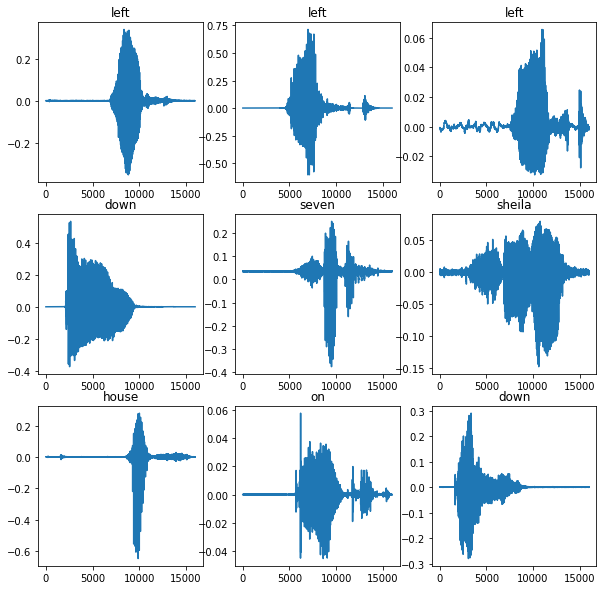

In [72]:
plt.figure(figsize=(10, 10))
row = 3
col = 3
for i in range(row*col):
    sample_file_dir = train_files[random.randint(0, len(train_files))].numpy()
    wabeform, label = waveform_and_label(sample_file_dir)
    plt.subplot(row, col, i+1)
    plt.plot(wabeform)
    plt.title(label.numpy().decode("utf-8"))


Great!

### Getting Spectrogram

Next step is to get the specrogram for each waveform. The spectrogram is what we'll be using to train our model. There are tidbits involved in converting a waveform to spectrogram:
1. The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be realized using zero-padding the audio clips that are shorter than one second (Audios are about one minute long on averge).
2. We'll be using `tf.signal.stft` for the conversion. The function accepts two parameters `frame_length` and `frame_step`. We have to chose these parameters in such a way that generated spectrogram is almost square.
3. The `tf.signal.stft` return an array of complex numbers. We'll be intersted in just the magnitude of it.

In [141]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Getting the spectrogran
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)

  # Add a `channels` dimension,
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Now that we have spectrogram, let's plot it.

In [97]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

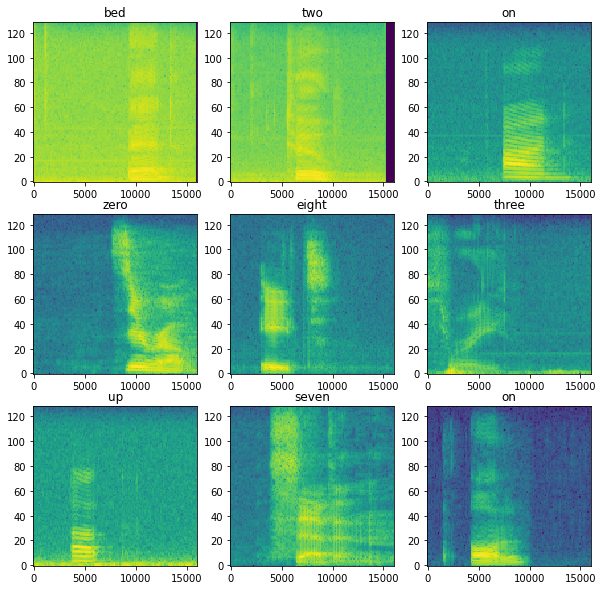

In [103]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i in range(rows*cols):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    sample_file_dir = train_files[random.randint(0, len(train_files))].numpy()
    waveform, label = waveform_and_label(sample_file_dir)
    spectrogram = get_spectrogram(waveform)
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(label.numpy().decode("utf-8"))

### Getting Label ID

Final step before we can make the tensorflow dataset is to get the label_id corresponding to label name. We'll use one hot encoded labels.

In [105]:
def create_label_id(label):
    return tf.cast((commands == label), dtype=tf.float32)

In [106]:
create_label_id(label)

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

### Create the DataSet

Using all the functions defined above, we create a final function which takes the directory of the audio file and returns the spectrogram and label_id.

In [107]:
def get_spectrogram_and_label_id(file_path):
    waveform, label = waveform_and_label(file_path)
    spectrogram = get_spectrogram(waveform)
    label = create_label_id(label)
    return spectrogram, label

Now we create the tensoflow dataset for all the three train, val and test splits.

In [135]:
AUTOTUNE = tf.data.AUTOTUNE
def preprocess_dataset(files):
    ds = tf.data.Dataset.from_tensor_slices(files)
    ds = ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return ds

In [110]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [111]:
train_ds

<ParallelMapDataset shapes: ((None, 129, 1), (30,)), types: (tf.float32, tf.float32)>

In [112]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

In [113]:
train_ds

<PrefetchDataset shapes: ((None, None, 129, 1), (None, 30)), types: (tf.float32, tf.float32)>

Excellent! Now we have everything we need to train a model. However, before training the model, we'll create another function which takes the directory of the audio file and returns just the spectrogram. This will be used during inference. 

In [140]:
def get_spectrogram_only(file_path):
    waveform= decode_audio(file_path)
    return get_spectrogram(waveform)

This should be all. Let's have a look at the shape of the spectrogram as well as the label returned by the `train_ds`.

In [116]:
for spectrogram, label in train_ds.take(1):
  input_shape = spectrogram[0].shape
print('Input shape:', input_shape)
print(label[0])
num_labels = len(commands)

Input shape: (124, 129, 1)
tf.Tensor(
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], shape=(30,), dtype=float32)


2022-06-23 05:17:06.422504: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Modeling

We'll be using a convolution network. Before passing the inputs to the conv layer, we'll be normalizing the data. Also, to avoid overfitting, we'll downsample the input shape. First step is done by the `Normalization` from `tensorflow.keras.layers` while the second can be done by the `Resizing` layer.

In [118]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

Here is the model.

In [123]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation="softmax"),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)       

In [124]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

In [125]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5, restore_best_weights=True),
)

Epoch 1/10
809/809 [==============================] - 6s 6ms/step - loss: 2.1610 - accuracy: 0.3696 - val_loss: 1.0602 - val_accuracy: 0.6924
Epoch 2/10
809/809 [==============================] - 5s 6ms/step - loss: 1.0057 - accuracy: 0.6987 - val_loss: 0.5999 - val_accuracy: 0.8313
Epoch 3/10
809/809 [==============================] - 5s 7ms/step - loss: 0.7942 - accuracy: 0.7674 - val_loss: 0.6082 - val_accuracy: 0.8220
Epoch 4/10
809/809 [==============================] - 5s 6ms/step - loss: 0.6987 - accuracy: 0.7965 - val_loss: 0.5193 - val_accuracy: 0.8490
Epoch 5/10
809/809 [==============================] - 5s 6ms/step - loss: 0.6351 - accuracy: 0.8146 - val_loss: 0.4508 - val_accuracy: 0.8711
Epoch 6/10
809/809 [==============================] - 5s 6ms/step - loss: 0.5910 - accuracy: 0.8276 - val_loss: 0.4136 - val_accuracy: 0.8840
Epoch 7/10
809/809 [==============================] - 5s 6ms/step - loss: 0.5604 - accuracy: 0.8363 - val_loss: 0.3905 - val_accuracy: 0.8864
Epoch 

The model is performing great! Just in 10 epochs, the val accuracy is over 90% and may still increase.

Here is the same model but instead of using `GlobalAveragePooling2D` the model uses `GlobalMaxPooling2D`.

In [128]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.GlobalMaxPooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation="softmax"),
])

model2.summary()

model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

EPOCHS = 10
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5, restore_best_weights=True),
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 64)       

This too, is performing great.

We'll leave the experiments. Let's evaluate the model and run inference.

In [130]:
model.evaluate(val_ds), model2.evaluate(val_ds)

102/102 [==============================] - 0s 3ms/step - loss: 0.3944 - accuracy: 0.8954


([0.42070043087005615, 0.8802533745765686],
 [0.3944089114665985, 0.8953955769538879])

Okay, 88% and 89.5% on validation set!

In [131]:
model.evaluate(test_ds), model2.evaluate(test_ds)

102/102 [==============================] - 0s 3ms/step - loss: 0.3906 - accuracy: 0.8968


([0.41125166416168213, 0.8825711011886597],
 [0.3906451165676117, 0.8967861533164978])

88.3% and 89.7% on test set. This is amazing!

We'll evaluate on train set too, to see if the model is overfitting.

In [132]:
model.evaluate(train_ds), model2.evaluate(train_ds)

809/809 [==============================] - 3s 4ms/step - loss: 0.3491 - accuracy: 0.9074


([0.3520302176475525, 0.8992003798484802],
 [0.3490503132343292, 0.9074281454086304])

So, the train accuracy is almost similar to the test accuracy. The models are not overfitting.

# Analysis

## Inference

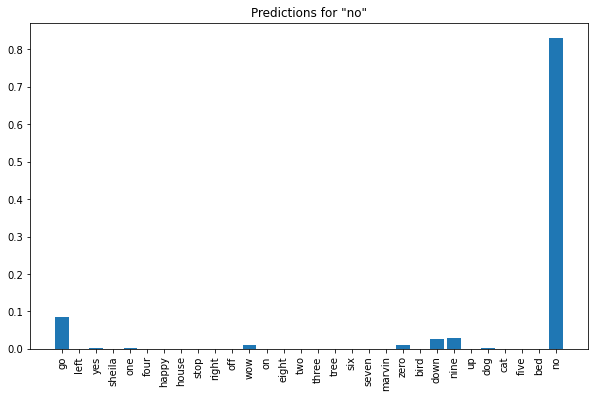

In [ ]:
sample_file = data_dir+'/no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([(sample_file)])

for spectrogram, label in sample_ds.batch(2):
  prediction = model(spectrogram)
  plt.figure(figsize=(10, 6))
  plt.bar(commands, (prediction[0]))
  plt.title(f'Predictions for "{commands[np.argmax(label[0])]}"')
  plt.xticks(rotation=90)
  plt.show()

The actual label of the `sample_file` is *no* and our model is also predicting the same.

### Saving the Model

> We can, if we want, save the model as an h5 file to be used later.

In [ ]:
model.save("model.h5")

In [ ]:
from IPython.display import FileLink
FileLink("model.h5")

## Analyzing the Predictions of the Model

### Plotting Confusion Matrix

In [217]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

In [206]:
preds = model.predict(val_ds)
preds = preds.argmax(axis=1)

In [208]:
y_true = []
for _, label in val_ds:
    y_true.append(label.numpy())

In [209]:
y_true = np.concatenate(y_true, axis=0)
y_true = y_true.argmax(axis=1)

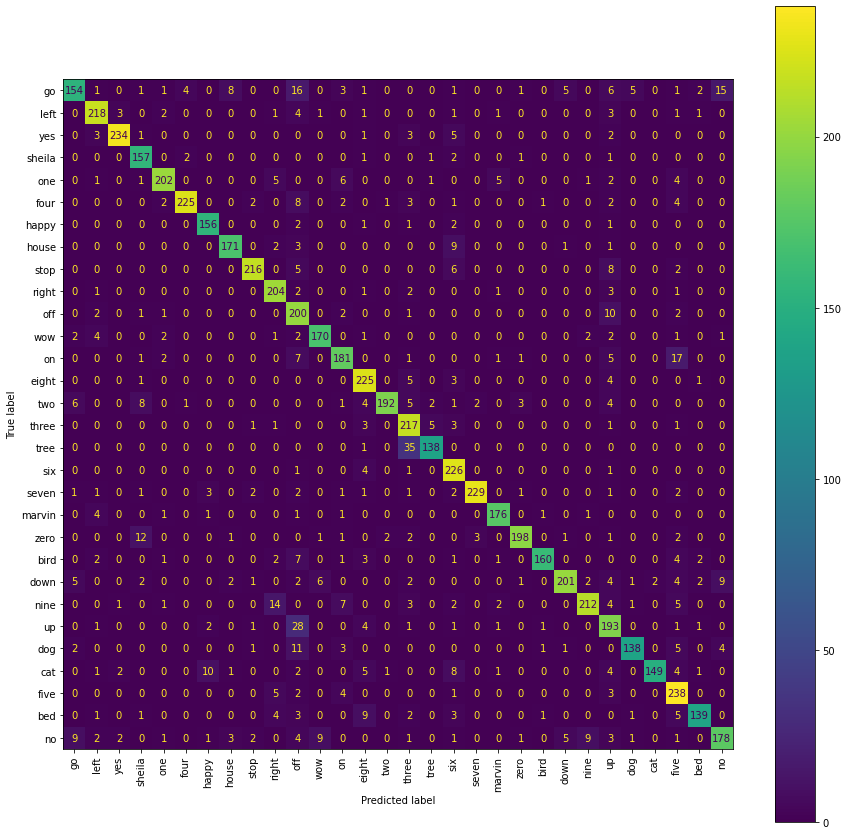

In [223]:
cm = confusion_matrix(y_true, preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=commands)
fig, ax = plt.subplots(figsize=((15, 15)))
cmp.plot(ax=ax, xticks_rotation='vertical')

We can see that the model is making some "honest" mistakes. It is getting confused between (tree, three), (up, off), (go, no), (night, right) etc.

## Creating the Submission File

Cells below are to make a submission files to submit on kaggle.

In [ ]:
test_files = tf.io.gfile.glob("test"+"/*/*")
len(test_files)

In [ ]:
test_files[:10]

In [ ]:
def get_clip_name(file):
    return tf.strings.split(
      input=file,
      sep=os.path.sep)[-1]


In [ ]:
get_clip_name(test_files[1])

In [ ]:
clip_ds = tf.data.Dataset.from_tensor_slices(test_files)
clip_ds = clip_ds.map(
    map_func=get_clip_name,
    num_parallel_calls=AUTOTUNE)

In [ ]:
def preprocess_test_data(file):
    audio_binary = tf.io.read_file(file)
    waveform = decode_audio(audio_binary)
    return get_spectrogram(waveform)

test_ds = tf.data.Dataset.from_tensor_slices(test_files)
test_ds = test_ds.map(
    map_func=preprocess_test_data,
    num_parallel_calls=AUTOTUNE)

In [ ]:
sample_sub = pd.read_csv("sample_submission.csv")
sample_sub

In [ ]:
# test_ds = preprocess_dataset(test_files)
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(AUTOTUNE)

clip_ds = clip_ds.batch(batch_size)
clip_ds = clip_ds.prefetch(AUTOTUNE)

In [ ]:
clip_ds

In [ ]:
import tqdm

In [ ]:
predictions = np.array([])
for data in tqdm.tqdm(test_ds, desc ="Predicting..."):
    pred = model.predict(data)
    pred = tf.argmax(pred, axis=1).numpy()
    pred = (commands[pred])
    predictions = np.append(predictions, pred)

In [ ]:
clips = np.array([])
for data in tqdm.tqdm(clip_ds, desc="Getting Clip Names..."):
    print(data.)

In [ ]:
clips = np.array([])
for data in tqdm.tqdm(clip_ds, desc="Getting Clip Names..."):
    clips = np.append(clips, data.numpy())

In [ ]:
predictions.shape, clips.shape

In [ ]:
sub = pd.DataFrame([clips, predictions]).T
sub.columns = ["fname", "label"]
sub.head()

In [ ]:
sub["fname"] = sub["fname"].apply(lambda x: x.decode('ascii'))

In [ ]:
possible_labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
def get_correct_label(label):
    if label in possible_labels:
        return label
    return 'unknown'

In [ ]:
sub["label"] = sub["label"].apply(get_correct_label)

In [ ]:
sub["label"].value_counts()

In [ ]:
sub = pd.merge(sample_sub, sub, on="fname")
sub.drop("label_x", axis=1, inplace=True)
sub.columns = ["fname", "label"]
sub

In [ ]:
sub.to_csv("first_submission.csv", index=False)

In [ ]:
from IPython.display import FileLink
FileLink("first_submission.csv")